In [1]:
!pip install geopandas

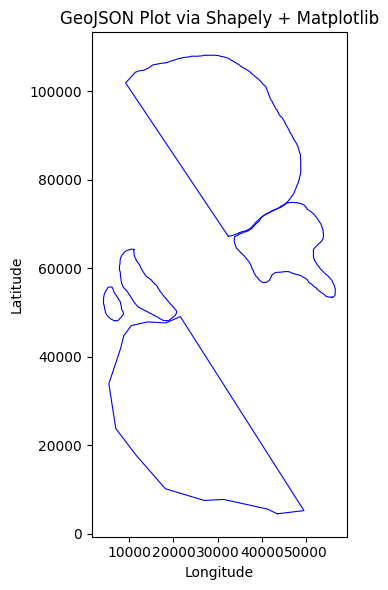

In [18]:
import json
from shapely.geometry import shape
import matplotlib.pyplot as plt

# 1. Load the GeoJSON as JSON

path = "/Users/ugursahin/Downloads/tumour_outlines_20221020095443.geojson"


with open(path, "r") as f:
    data = json.load(f)

# 2. Determine how the features are stored
if isinstance(data, dict) and "features" in data:
    features = data["features"]
elif isinstance(data, list) and all(isinstance(item, dict) and item.get("type") == "Feature" for item in data):
    # bare list of Feature dicts
    features = data
else:
    raise ValueError("Unrecognized GeoJSON structure. "
                     "Expected a FeatureCollection or a list of Feature objects.")

# 3. Extract Shapely geometries from each feature
geoms = [shape(feat["geometry"]) for feat in features]

# 4. Plot manually based on geometry type
fig, ax = plt.subplots(figsize=(8, 6))

for geom in geoms:
    geom_type = geom.geom_type
    if geom_type in ("Polygon", "MultiPolygon"):
        if geom_type == "Polygon":
            polygons = [geom]
        else:
            polygons = list(geom.geoms)
        for poly in polygons:
            x, y = poly.exterior.xy
            ax.plot(x, y, color="blue", linewidth=0.8)
    elif geom_type in ("LineString", "MultiLineString"):
        if geom_type == "LineString":
            lines = [geom]
        else:
            lines = list(geom.geoms)
        for line in lines:
            x, y = line.xy
            ax.plot(x, y, color="green", linewidth=0.8)
    elif geom_type == "Point":
        x, y = geom.xy
        ax.scatter(x, y, color="red", s=10)
    else:
        # e.g. GeometryCollection, etc. You can add more cases if needed.
        pass

ax.set_aspect("equal", "box")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("GeoJSON Plot via Shapely + Matplotlib")
plt.tight_layout()
plt.show()

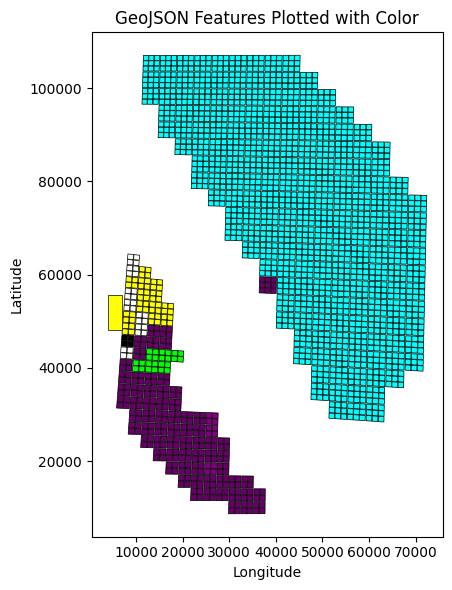

In [16]:
import json
from shapely.geometry import shape
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def normalize_color(raw):
    """
    Given a raw 'color' property from GeoJSON, return something Matplotlib can accept:
      - Hex strings ("#rrggbb") or named colors ("blue") → passed through.
      - Tuples/lists of 3 or 4 integers in 0–255 range → converted to floats in 0–1 range.
      - Anything else → return a default gray.
    """
    # 1. If it's already a string, check if Matplotlib recognizes it.
    if isinstance(raw, str):
        try:
            # This will raise ValueError if it's not a valid color name/hex
            _ = mcolors.to_rgba(raw)
            return raw
        except ValueError:
            return "#cccccc"  # fallback gray

    # 2. If it's a list/tuple of numbers, assume RGB(A) 0–255
    if isinstance(raw, (list, tuple)):
        # Convert all elements to float and check length
        vals = [float(v) for v in raw]
        if len(vals) == 3:
            # RGB → convert to 0–1 floats
            r, g, b = [v / 255.0 for v in vals]
            return (r, g, b)
        elif len(vals) == 4:
            # RGBA → convert to 0–1 floats
            r, g, b, a = [v / 255.0 for v in vals]
            return (r, g, b, a)
        else:
            return "#cccccc"

    # 3. Otherwise, fallback
    return "#cccccc"


# ------------------------------------------------------------
# 1. Load the GeoJSON as JSON
geojson_path = "/Users/ugursahin/Downloads/cna_all_tiles_20221020095443.geojson"

with open(geojson_path, "r") as f:
    data = json.load(f)

# 2. Normalize into a list of “feature” dicts
if isinstance(data, dict) and "features" in data:
    features = data["features"]
elif isinstance(data, list) and all(
    isinstance(item, dict) and item.get("type") == "Feature" for item in data
):
    features = data
else:
    raise ValueError("Unrecognized GeoJSON structure. Expected a FeatureCollection or list of Features.")

# 3. Build a list of (Shapely‐geom, normalized_color)
geom_color_list = []
for feat in features:
    geom = shape(feat["geometry"])
    props = feat.get("properties", {})
    raw_color = props.get("color", None)
    color = normalize_color(raw_color)
    geom_color_list.append((geom, color))

# 4. Plot everything with Matplotlib, using each feature’s color
fig, ax = plt.subplots(figsize=(8, 6))

for geom, color in geom_color_list:
    geom_type = geom.geom_type

    if geom_type in ("Polygon", "MultiPolygon"):
        # Break MultiPolygon into individual Polygons
        polygons = [geom] if geom_type == "Polygon" else list(geom.geoms)
        for poly in polygons:
            # Exterior ring
            x, y = poly.exterior.xy
            ax.fill(
                x, y,
                facecolor=color,
                edgecolor="black",
                linewidth=0.5,
                alpha=1.0  # if you want semi‐transparency, adjust here
            )
            # Interiors (holes)
            for interior in poly.interiors:
                xi, yi = interior.xy
                ax.fill(xi, yi, facecolor="white", edgecolor="black", linewidth=0.5)

    elif geom_type in ("LineString", "MultiLineString"):
        lines = [geom] if geom_type == "LineString" else list(geom.geoms)
        for line in lines:
            x, y = line.xy
            ax.plot(x, y, color=color, linewidth=1.0)

    elif geom_type == "Point":
        x, y = geom.xy
        ax.scatter(x, y, color=color, s=20, edgecolor="black", linewidth=0.3)

    else:
        # (Optional) handle GeometryCollection or other types if needed
        pass

ax.set_aspect("equal", "box")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("GeoJSON Features Plotted with Color")
plt.tight_layout()
plt.show()

In [7]:
!pip install fiona

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 12.3 MB/s eta 0:00:00a 0:00:01


ValueError: aspect must be finite and positive 

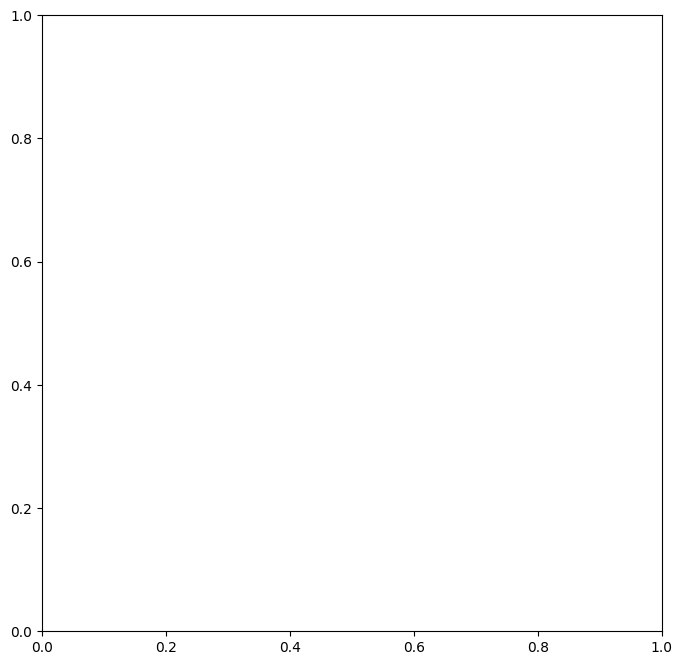

In [27]:
import json
import numpy as np
import pandas as pd
import spatialdata as sd
import geopandas as gpd
import fiona

from geopandas import GeoDataFrame
from shapely import Polygon
from spatialdata.models import ShapesModel
from spatialdata.transformations import Identity

import spatialdata_plot  # noqa: F401

with open("/Users/ugursahin/Downloads/cna_all_tiles_20221020095443.geojson", "r") as f:
    data = json.load(f)

#pd.DataFrame(gdf["geometry"].to_dict())
# shape0 = np.array([df[0].to_list(), df[1].to_list() ])
#pd.DataFrame(gdf["geometry"].to_list())

# def numpy_to_shapely(x: np.array) -> Polygon:
#     return Polygon(list(map(tuple, x.T)))


# gdf = GeoDataFrame({"geometry": [numpy_to_shapely(shape0)]})
# gdf = ShapesModel.parse(gdf, transformations={"aligned": Identity()})

gdf = gpd.GeoDataFrame.from_features(data, crs="EPSG:4326")
shapes_df = ShapesModel.parse(gdf, transformations={"pixels": Identity()})


# If you want to view shapes_df as a GeoDataFrame again:
aligned_gdf = gpd.GeoDataFrame(
    shapes_df,
    geometry="geometry",
    crs="EPSG:4326"
)

# ── 3) Plot with geopandas/Matplotlib using the "color" column ─────────────
# Make sure your GeoDataFrame has a column named "color". If not, replace 
# "color" below with the actual column name that holds color strings.

fig, ax = plt.subplots(figsize=(8, 8))

# If your GeoDataFrame already has a “color” column containing hex strings or color names:
aligned_gdf.plot(
    ax=ax,
    color=aligned_gdf["color"],   # directly pass the color array
    edgecolor="black",
    linewidth=0.5
)

ax.set_title("GeoJSON Features Colored by 'color' Property")
ax.set_axis_off()  # turn off axes if desired
plt.show()